<a href="https://colab.research.google.com/github/OnurKerimoglu/bayesian_mmm/blob/main/bayesian_mmm_example_robert_kuebler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From: https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a

By Robert Kübler

# Install / Import Packages

In [2]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=5385ec936b31baf50cf538d1866c0887d9c828738a57be9d0300cd2d534fc61d
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [93]:
import pandas as pd
import numpy as np
import pymc3 as pm3
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


# Prepare Data

In [4]:
data = pd.read_csv(
  'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
  parse_dates=['Date'],
  index_col='Date'
)

X = data.drop(columns=['Sales'])
y = data['Sales']

# Define Model

In [5]:
import theano.tensor as tt

def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [32]:
import theano

def carryover_geometric(x, theta):
    x = tt.as_tensor_variable(x)
    #x = tt.vector("x")
    #theta = tt.scalar("theta")

    def adstock_geometric_recurrence_theano(index, input_x, decay_x, theta):
        return tt.set_subtensor(decay_x[index], tt.sum(input_x + theta * decay_x[index - 1]))

    len_observed = x.shape[0]

    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])

    output, _ = theano.scan(
        fn = adstock_geometric_recurrence_theano, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]

## The MMM Model

In [59]:
#old: with satuaration, no trend, no seasonality
import pymc3 as pm3

with pm3.Model() as mmm0:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm3.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm3.Exponential(f'sat_{channel}', lam=1)
        car = pm3.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm3.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm3.Exponential('base', lam=0.0001)
    noise = pm3.Exponential('noise', lam=0.0001)
    
    sales = pm3.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )

## Do prior distributions make sense?

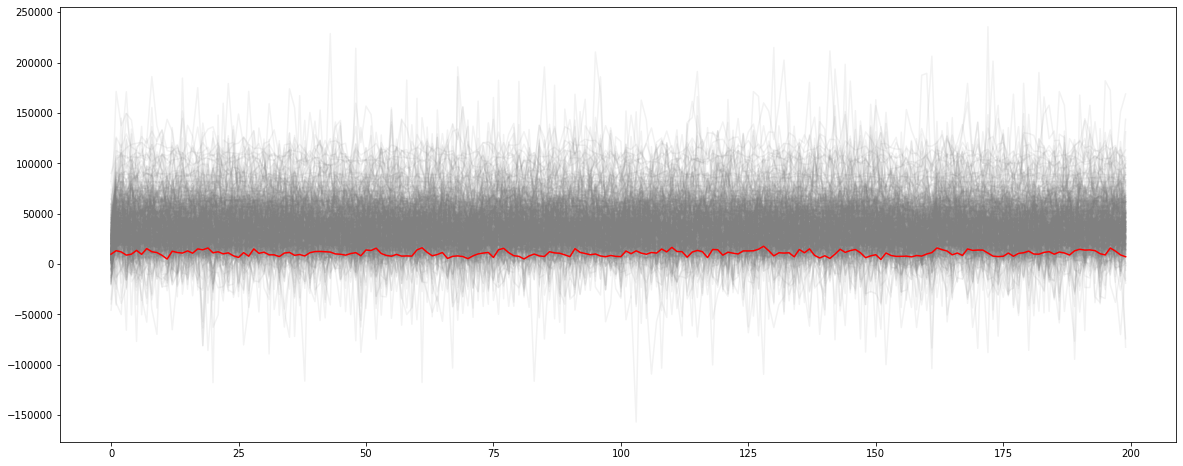

In [60]:
with mmm0:
    prior_pred = pm3.sample_prior_predictive()
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["sales"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(y.values, color = "red")

carryover priors: 3
sat priors: 3
coef priors: 3
sigma prior: 1


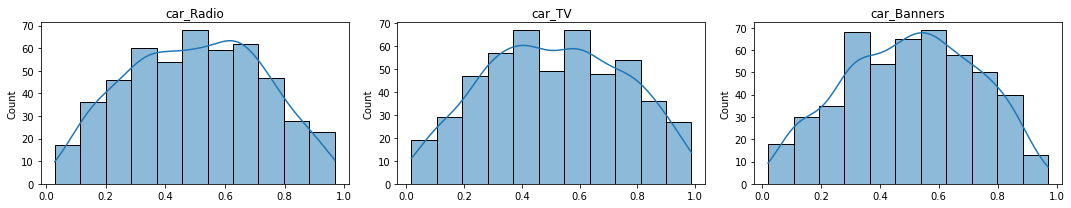

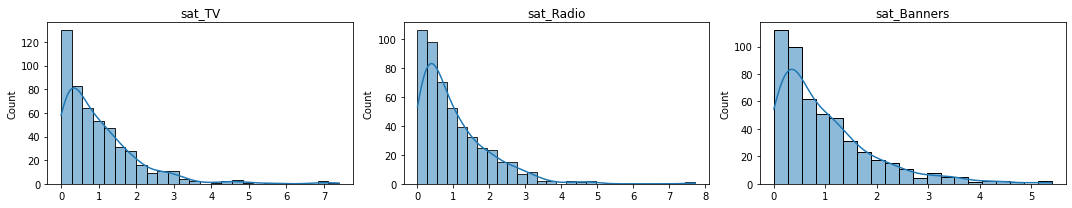

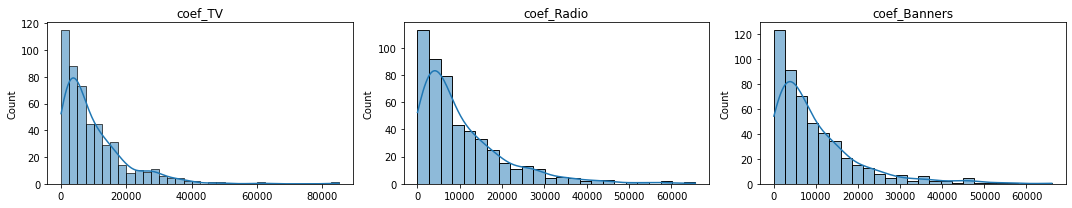

In [63]:
#from https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb

import seaborn as sns
import math

#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm3.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 3
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm3.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    

adstock_priors = [p for p in prior_names if p.startswith("car")]
plot_priors(adstock_priors, prior_pred)
print(f"carryover priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.startswith("sat")]
plot_priors(alpha_priors, prior_pred)
print(f"sat priors: {len(alpha_priors)}")

media_coef_priors = [p for p in prior_names if p.startswith("coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"coef priors: {len(media_coef_priors)}")

# control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
# plot_priors(control_coef_priors, prior_pred)
# print(f"control coef priors: {len(control_coef_priors)}")

#plot_priors(["sigma"], prior_pred)

print(f"sigma prior: 1")

## Fit the model

In [64]:
import arviz as az
with mmm0:
  trace = pm3.sample(return_inferencedata=True, tune=3000)
  trace_summary = az.summary(trace)

ERROR:pymc3:There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


## Posterior distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50853d8ca0>,
      dtype=object)

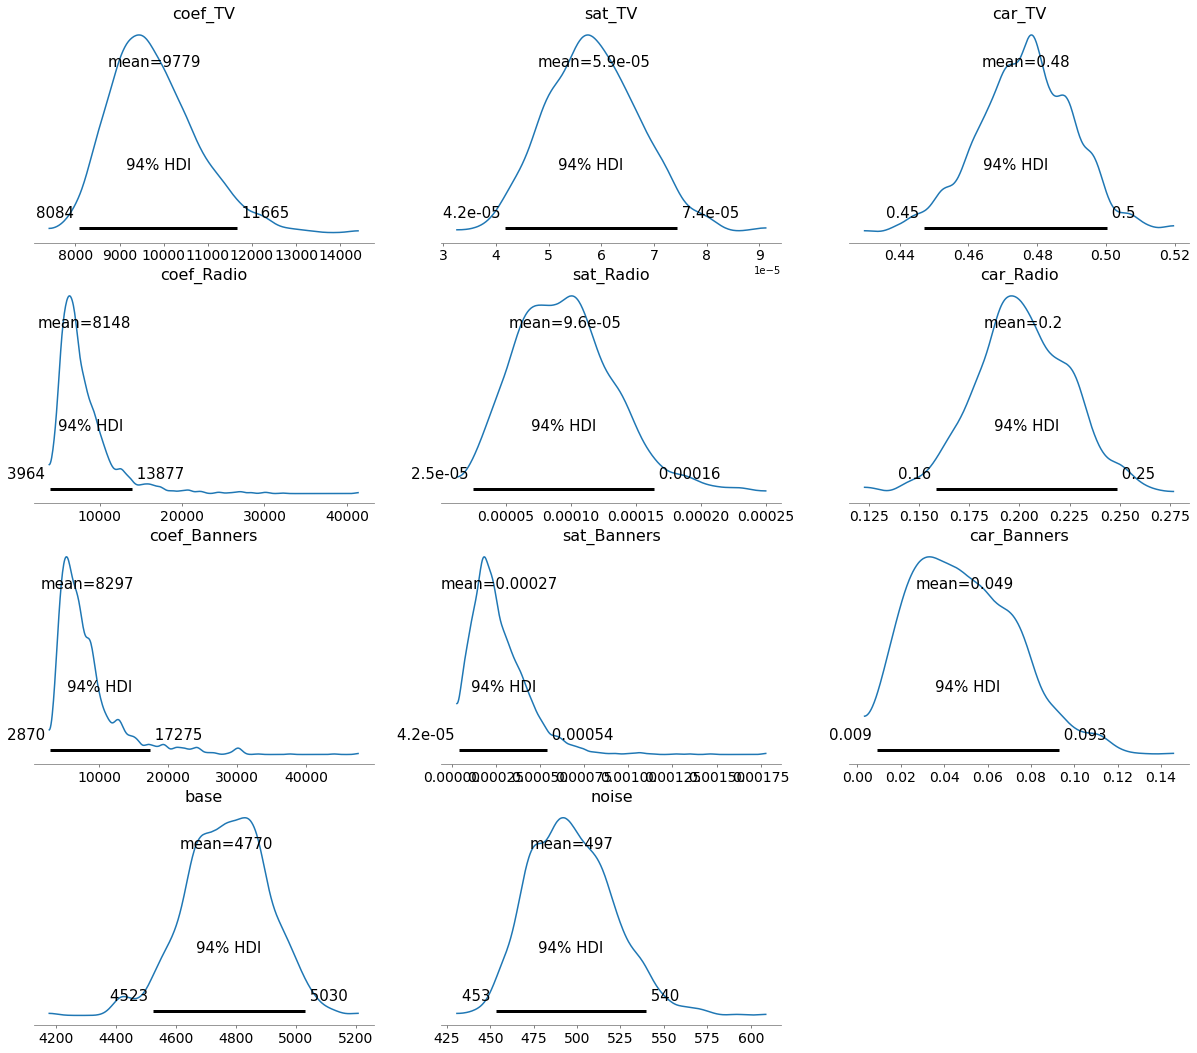

In [65]:
import arviz as az

az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

## Predictions vs Observations

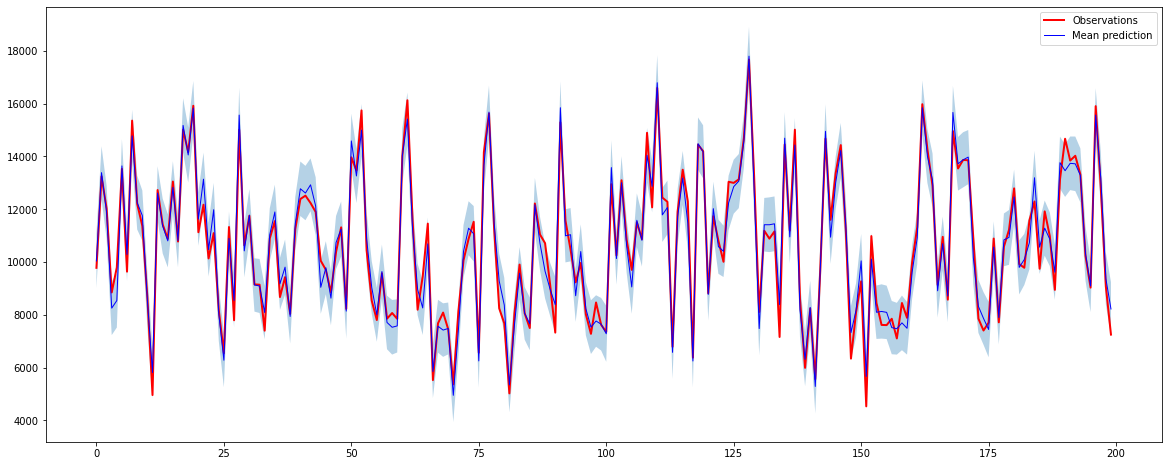

In [67]:
import matplotlib.pyplot as plt
import numpy as np

with mmm0:
    posterior = pm3.sample_posterior_predictive(trace)

means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)

plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

## Channel Contributions

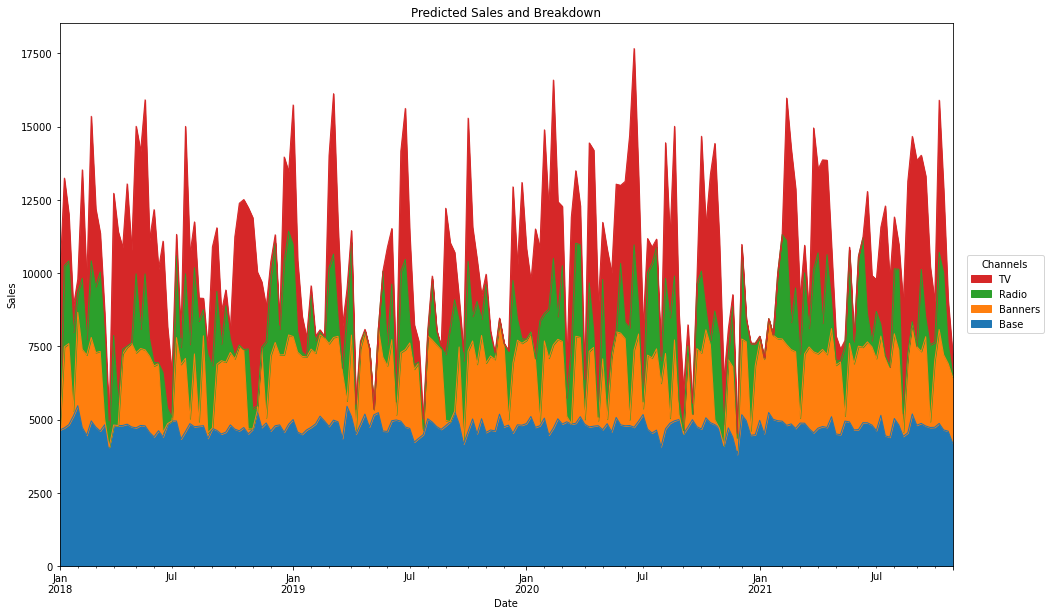

In [69]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            #.reshape(4000, 200)
            .reshape(2000, 200)
            .mean(0)
           )

channels = ['Banners', 'Radio', 'TV']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

#Model 2: no sat, seasonality, trend

In [107]:
from prophet import Prophet

In [126]:
data_wdates = pd.read_csv(
  'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
  parse_dates=['Date'],
  #keep_date_col = True,
  #index_col='Date'
)

In [128]:
prophet_data = data_wdates.rename(columns = {'Sales': 'y', 'Date': 'ds'})

prophet = Prophet(yearly_seasonality=True)

prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6v75a15/rhgpbi3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6v75a15/qh42soz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9999', 'data', 'file=/tmp/tmpd6v75a15/rhgpbi3r.json', 'init=/tmp/tmpd6v75a15/qh42soz7.json', 'output', 'file=/tmp/tmpd6v75a15/prophet_modeljbqs8d8d/prophet_model-20230125215058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:50:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


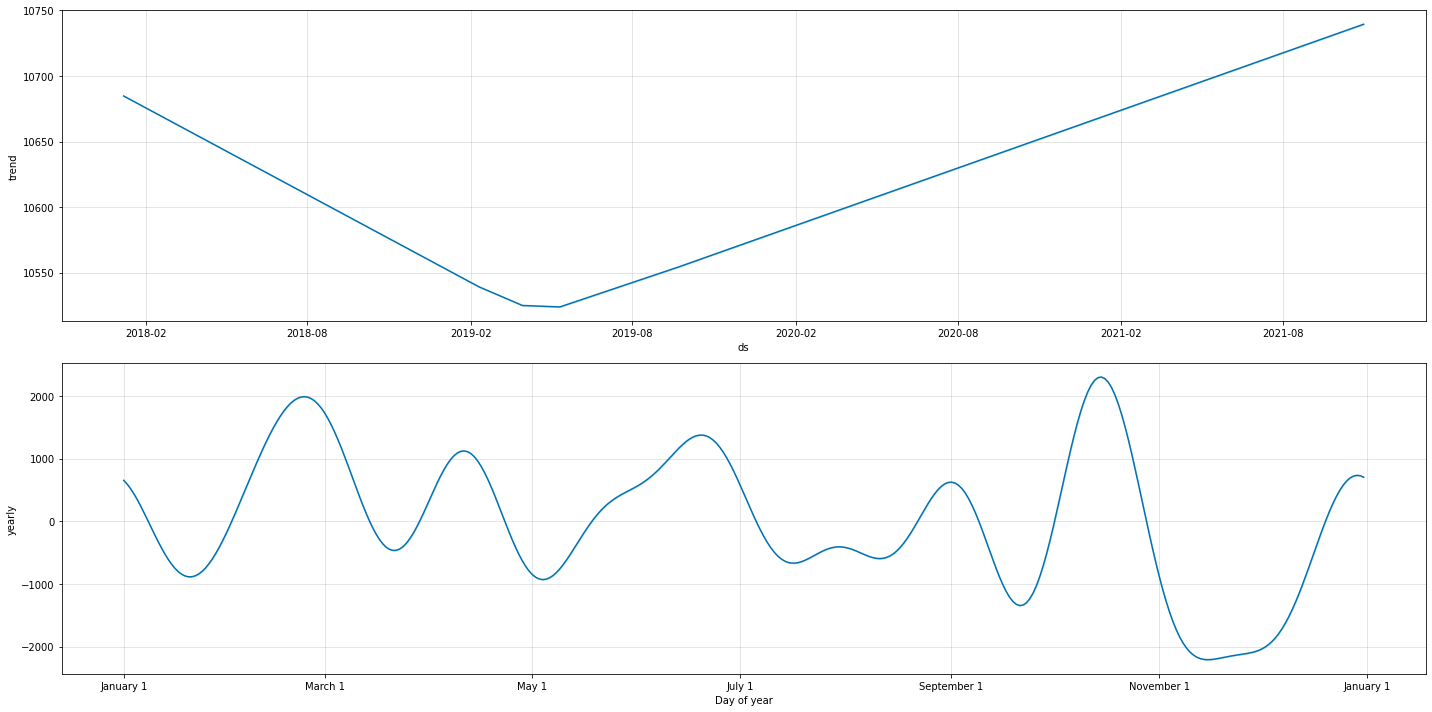

In [129]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [130]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)

final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]

In [131]:
X = final_data.drop(columns=['Sales', 'Date'])
y = final_data['Sales']

In [ ]:
response_mean = []
with pm3.Model() as mmm2:
    for channel in X.columns: #delay channels
        print(f"Delay Channels: Adding {channel}")
        
        x = X[channel].values
        
        
        
        adstock_param = pm3.Beta(f"{channel}_carryover", 3, 3)
        #saturation_gamma = pm.Beta(f"{channel}_gamma", 2, 2)
        #saturation_alpha = pm.Gamma(f"{channel}_alpha", 3, 1)
        
        x_new = carryover_geometric(x, adstock_param)
        #x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        #saturation_tensor = saturation_hill_pymc3(x_new, saturation_alpha, saturation_gamma)
        
        #we force positive coefficients
        channel_b = pm3.HalfNormal(f"{channel}_media_coef", sigma = 3)
        #response_mean.append(saturation_tensor * channel_b)
        response_mean.append(x_new * channel_b)
        
    # for control_var in control_variables:
    #     print(f"Control Variables: Adding {control_var}")
        
    #     x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
    #     control_beta = pm.Normal(f"{control_var}_control_coef", sigma = 3)
    #     control_x = control_beta * x
    #     response_mean.append(control_x)
        
    #intercept = pm3.Normal("intercept", np.mean(data_transformed[target].values), sigma = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    #sigma = pm.HalfNormal("sigma", 4)
    
   # likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sigma = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
        

In [134]:
#new: no saturation, 
import pymc3 as pm3

control_variables = ["trend", "season"]
delay_channels = ['TV','Radio','Banners']
transform_variables = ['TV','Radio','Banners', "trend", "season"]

y_transformed=y/1000

X_transformed = X.copy()

numerical_encoder_dict = {}
for feature in transform_variables:
    scaler = MinMaxScaler()
    original = final_data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    X_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

with pm3.Model() as mmm1:
    channel_contributions = []
    
    for channel in delay_channels:
        print(f"Delay channels: Adding {channel}")
        #coef = pm3.Exponential(f'coef_{channel}', lam=0.1)
        coef = pm3.HalfNormal(f'coef_{channel}', sigma = 2)
        #sat = pm3.Exponential(f'sat_{channel}', lam=1)
        car = pm3.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X_transformed[channel].values
        channel_contribution = pm3.Deterministic(
            f'contribution_{channel}',
            coef * carryover(
                    channel_data,
                    car),
            )
        
        channel_contributions.append(channel_contribution)
    
    control_contributions = []
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
  
        x = X_transformed[control_var].values
  
        control_beta = pm3.Normal(f"control_{control_var}", sigma = 3)
        control_x = control_beta * x
        control_contributions.append(control_x)

    base = pm3.Normal("base", np.mean(y_transformed.values), sigma = 2)
    #base = pm3.Exponential('base', lam=0.01)
    noise = pm3.Exponential('noise', lam=0.1)

    sales = pm3.Normal(
        'sales',
        mu= base + sum(control_contributions) + sum(channel_contributions),
        sigma=noise,
        observed=y_transformed
    )

Delay channels: Adding TV
Delay channels: Adding Radio
Delay channels: Adding Banners
Control Variables: Adding trend
Control Variables: Adding season


## Do prior distributions make sense?

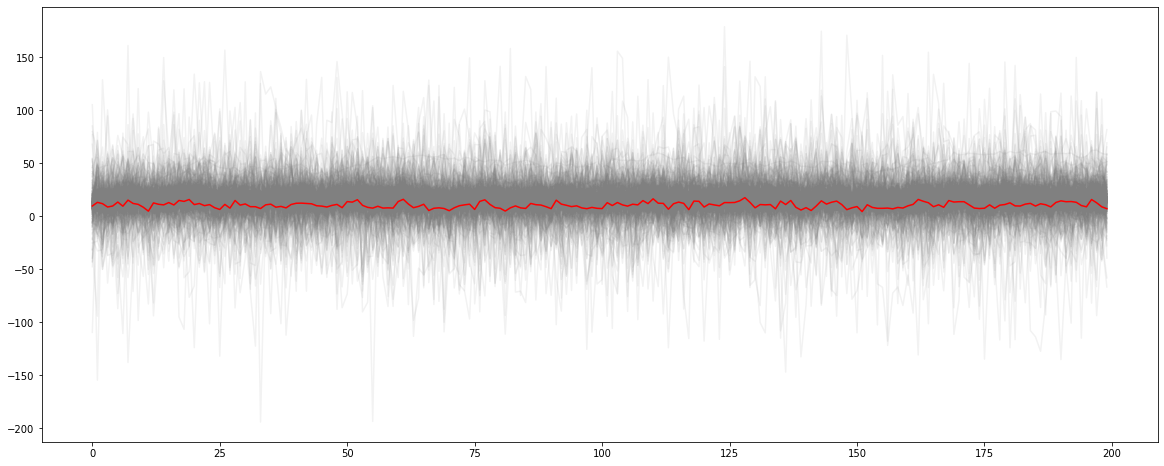

In [135]:
with mmm1:
    prior_pred = pm3.sample_prior_predictive()
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["sales"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(y_transformed.values, color = "red")

carryover priors: 3
coef priors: 3
control coef priors: 3
sigma prior: 1


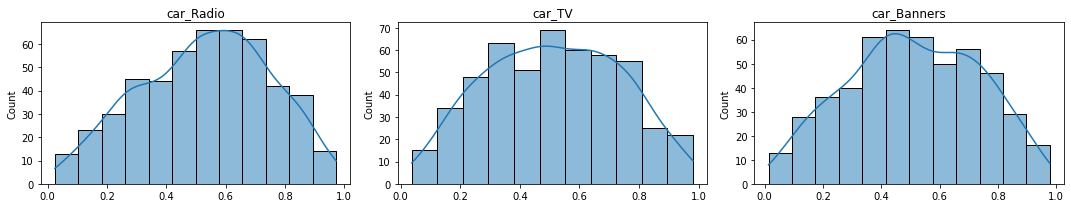

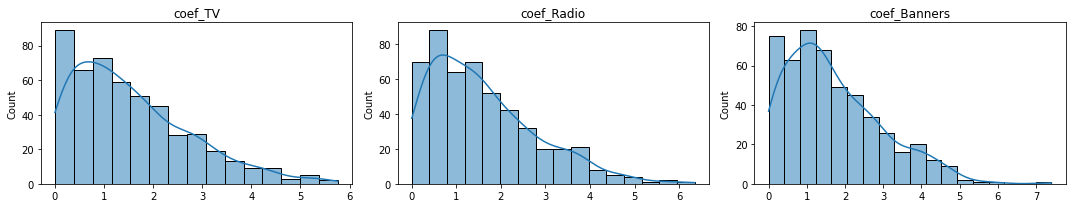

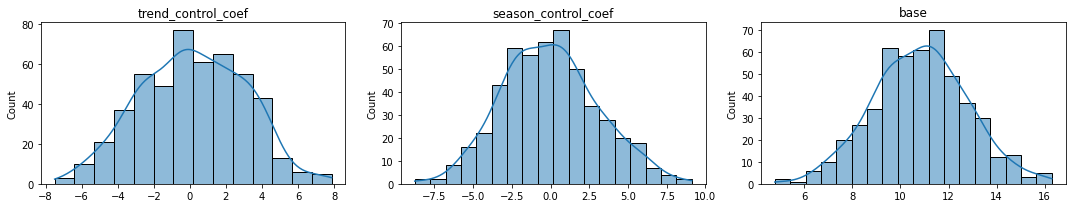

In [137]:
#from https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb

import seaborn as sns
import math

#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm3.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 3
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm3.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    

adstock_priors = [p for p in prior_names if p.startswith("car")]
plot_priors(adstock_priors, prior_pred)
print(f"carryover priors: {len(adstock_priors)}")

# alpha_priors = [p for p in prior_names if p.startswith("sat")]
# plot_priors(alpha_priors, prior_pred)
# print(f"sat priors: {len(alpha_priors)}")

media_coef_priors = [p for p in prior_names if p.startswith("coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["base"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

#plot_priors(["sigma"], prior_pred)

print(f"sigma prior: 1")

## Fit the model

In [138]:
import arviz as az
with mmm1:
  trace = pm3.sample(return_inferencedata=True, tune=3000)
  trace_summary = az.summary(trace)

/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


## Posterior distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50781bd040>,
      dtype=object)

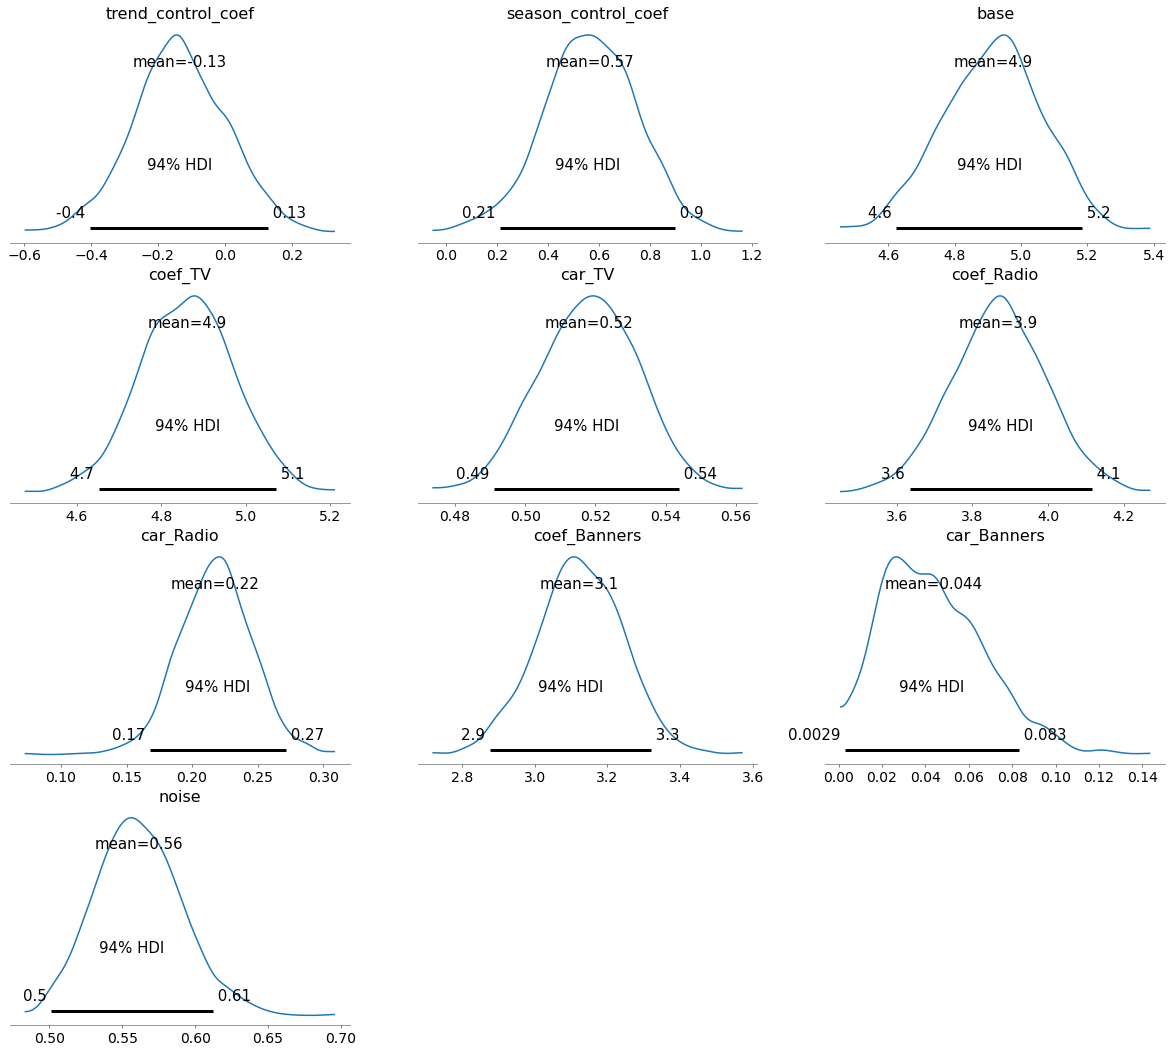

In [139]:
import arviz as az

az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

## Predictions vs Observations

In [140]:
import matplotlib.pyplot as plt
import numpy as np

with mmm1:
    posterior = pm3.sample_posterior_predictive(trace)

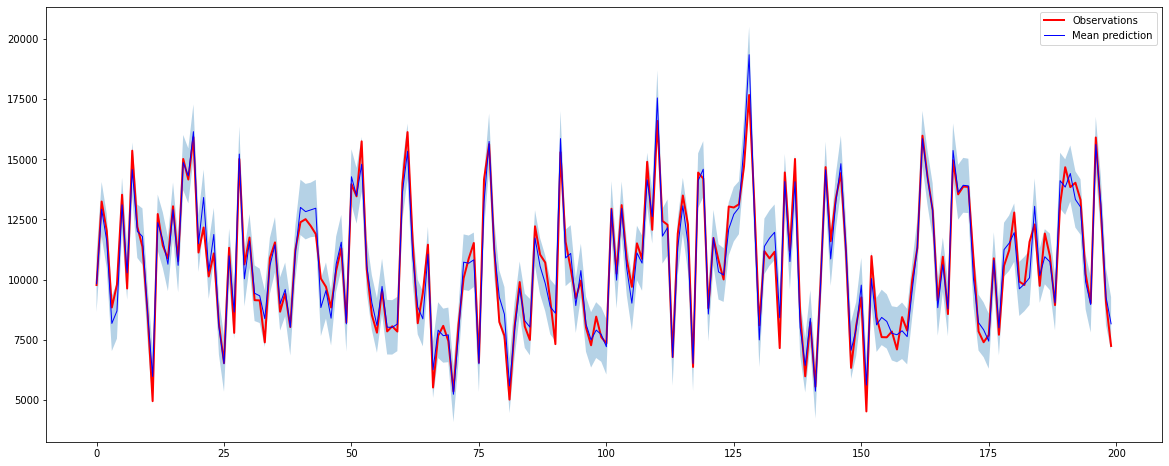

In [141]:
means = posterior['sales'].mean(0)*1000
stds = posterior['sales'].std(0)*1000

plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

## Channel Contributions

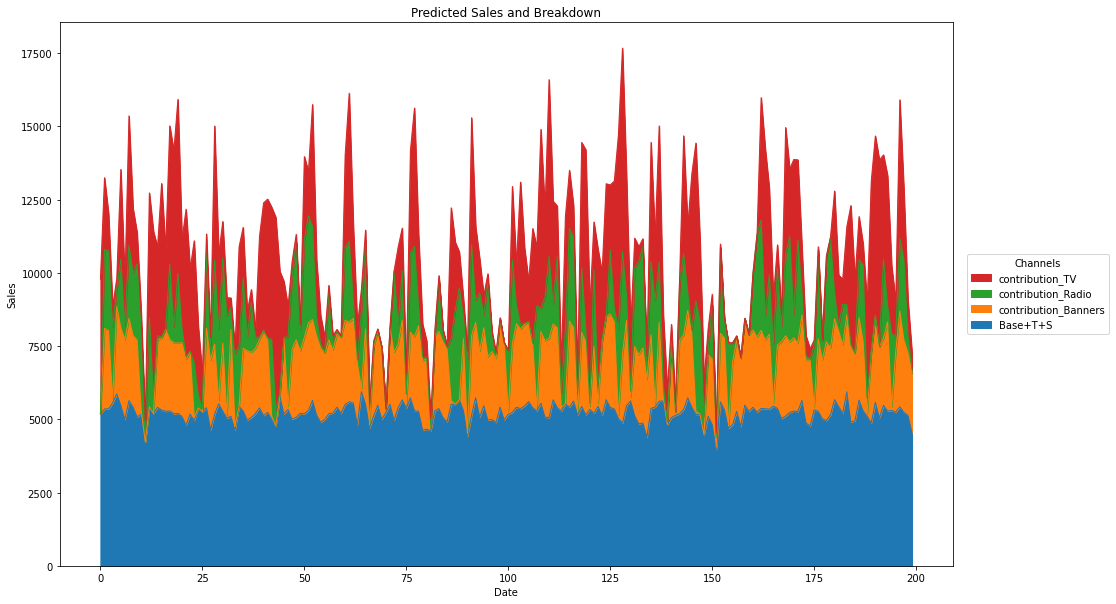

In [149]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'{channel}']
            .values
            #.reshape(4000, 200)
            .reshape(2000, 200)
            .mean(0)
           )

channels = ['contribution_Banners', 'contribution_Radio', 'contribution_TV']
unadj_contributions = pd.DataFrame(
    {'Base+T+S': trace.posterior['base'].values.mean()
                 +trace.posterior['trend_control_coef'].values.mean()
                 +trace.posterior['season_control_coef'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)